### import modules

In [1]:
import os
import sys
import math
import copy
import time
import struct
import numpy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
%matplotlib inline
from scipy import misc
from scipy.ndimage import rotate
import return_KTcmap
import mpl_toolkits.axes_grid1

cos = np.cos
sin = np.sin
d2r = np.deg2rad

In [2]:
font = 'Helvetica'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font + ':italic'
plt.rcParams['mathtext.bf'] = font + ':bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

### encode binary file

In [4]:
#-=-=-=-=--=-=-=-=-=-=INITIALISATIONS-=-=-=-=-=-=--=-=-=-=
kpc_cgs= 3.08567758e21
G_cgs  = 6.67e-8
Mo_cgs = 1.99e33
sec2myr= 60.*60.*24.*365.*1e6
umass = 1.0 
udist = 1.0 
uvel  = np.sqrt( G_cgs * umass * Mo_cgs / (udist * kpc_cgs) )/1e5
udens = umass * Mo_cgs / (udist * kpc_cgs)**3.
utime = np.sqrt(1./(udens * G_cgs))
print('<<<<<<<<<GASOLINE UNITS>>>>>>>>>')
print('udist =',udist,'[kpc]')
print('umass =',umass,'[Mo]')
print('uvel  =',uvel,'[km/s]')
print('udens =',udens,'[g/cm3]')
print('utime =',utime,'[s]')

def rtipsy(filename, VERBOSE=False):
    """rtipsy Reads tipsy files detecting the format: 
    big endian, little endian, padded (standard) or non-padded header 

    Usage: 
          rtipsy(filename, VERBOSE=False)

    Input parameters: 
    filename  filename string
    VERBOSE  print(messages (optional)
    Return values:
    (header,g,d,s)
    header    tipsy header struct
    g,d,s     gas, dark and star structures
    Please read rtipsy.py for the structure definitions

    Example: 
    h,g,d,s = rtipsy('/home/wadsley/usr5/mihos/mihos.std')
    print, h['ndark']
    plt.plot(d['x'], d['y'], 'k,')"""
    try:
        f = open(filename, 'rb')
    except:
        print("RTIPSY ERROR: Can't open file")
        return 1
    fs = len(f.read())
    f.seek(0)
    #Read in the header
    t, n, ndim, ng, nd, ns = struct.unpack("<diiiii", f.read(28))
    endianswap = False
    #Check Endianness
    if (ndim < 1 or ndim > 3):
        endianswap = True
        f.seek(0)
        t, n, ndim, ng, nd, ns = struct.unpack(">diiiii", f.read(28))
        if VERBOSE:
            print("SWAP_ENDIAN")
    if VERBOSE:
        print("Read time,n,ngas,ndark,nstar: ", t, n, ng, nd, ns)
    #Catch for 4 byte padding
    if (fs == 32+48*ng+36*nd+44*ns):
        f.read(4)
    #File is borked if this is true
    elif (fs != 28+48*ng+36*nd+44*ns):
        print("RTIPSY ERROR: Header and file size inconsistent")
        print("Estimates: Header bytes:  28 or 32 (either is OK)")
        print("     ngas: ",ng," bytes:",48*ng)
        print("    ndark: ",nd," bytes:",36*nd)
        print("    nstar: ",ns," bytes:",44*ns)
        print("Actual File bytes:",fs,"  not one of:",28+48*ng+36*nd+44*ns,32+48*ng+36*nd+44*ns)
        f.close()
        return 1
    
    catg = {'mass':np.zeros(ng), 'pos':np.zeros((ng,3)), 'vel':np.zeros((ng,3)), 'dens':np.zeros(ng),
            'tempg':np.zeros(ng), 'h':np.zeros(ng), 'zmetal':np.zeros(ng),    'phi':np.zeros(ng)}
    catd = {'mass':np.zeros(nd), 'pos':np.zeros((nd,3)), 'vel':np.zeros((nd,3)),
            'eps':np.zeros(nd), 'phi':np.zeros(nd)}
    cats = {'mass':np.zeros(ns), 'pos':np.zeros((ns,3)), 'vel':np.zeros((ns,3)),
            'metals':np.zeros(ns), 'tform':np.zeros(ns), 'eps':np.zeros(ns), 'phi':np.zeros(ns)}
    for cat in ['g','d','s']:
        j = 0
        for qty in ['x','y','z']:
            locals()['cat'+cat][qty] = locals()['cat'+cat]['pos'][:,j]
            locals()['cat'+cat]['v'+qty] = locals()['cat'+cat]['vel'][:,j]
            j += 1    
            
    if (ng > 0):
        for i in range(ng):
            if endianswap:
                mass, x, y, z, vx, vy, vz, dens, tempg, h, zmetal, phi = struct.unpack(">ffffffffffff", f.read(48))
            else:
                mass, x, y, z, vx, vy, vz, dens, tempg, h, zmetal, phi = struct.unpack("<ffffffffffff", f.read(48))
            catg['mass'][i] = mass
            catg['x'][i] = x
            catg['y'][i] = y
            catg['z'][i] = z
            catg['vx'][i] = vx
            catg['vy'][i] = vy
            catg['vz'][i] = vz
            catg['dens'][i] = dens
            catg['tempg'][i] = tempg
            catg['h'][i] = h
            catg['zmetal'][i] = zmetal
            catg['phi'][i] = phi
    if (nd > 0):
        for i in range(nd):
            if endianswap:
                mass, x, y, z, vx, vy, vz, eps, phi = struct.unpack(">fffffffff", f.read(36))
            else:
                mass, x, y, z, vx, vy, vz, eps, phi = struct.unpack("<fffffffff", f.read(36))
            catd['mass'][i] = mass
            catd['x'][i] = x
            catd['y'][i] = y
            catd['z'][i] = z
            catd['vx'][i] = vx
            catd['vy'][i] = vy
            catd['vz'][i] = vz
            catd['eps'][i] = eps
            catd['phi'][i] = phi
    if (ns > 0):
        for i in range(ns):
            if endianswap:
                mass, x, y, z, vx, vy, vz, metals, tform, eps, phi = struct.unpack(">fffffffffff", f.read(44))
            else:
                mass, x, y, z, vx, vy, vz, metals, tform, eps, phi = struct.unpack("<fffffffffff", f.read(44))
            cats['mass'][i] = mass
            cats['x'][i] = x
            cats['y'][i] = y
            cats['z'][i] = z
            cats['vx'][i] = vx
            cats['vy'][i] = vy
            cats['vz'][i] = vz
            cats['metals'][i] = metals
            cats['tform'][i] = tform
            cats['eps'][i] = eps
            cats['phi'][i] = phi
    header = {'time':t, 'n':n, 'ndim':ndim, 'ngas':ng, 'ndark':nd, 'nstar':ns}
    
    return (header,catg,catd,cats)            

#-=-=-=-=-=-=--=-=-=-=-=-=READ IN=-=-=-=-=-=--=-=-=-=-=-=-
print('<<<<<<<<<RUN TIME>>>>>>>>>')

#  read in the data from a command line argument
#  e.g. >>python pytipsy_M51.py GLM.00310

filenom = '../data/GLM.00310'

header,catg,catd,cats = rtipsy(filenom,True)

#  calculate time and smoothing lengths (from cubic spline kernel)
hi = 0.98 * (catg['mass']/catg['dens'])**(1./3.)
ti = header['time']*utime/sec2myr
npartG  = header['ngas']
npartH  = header['ndark']
npartS  = header['nstar']
print('Time of dump:',ti,'[Myr]')
print('--------------------')
print('   Type   |    N    ')
print('--------------------')  
print('   Gas    |  ',npartG)
print('   Halo   |  ',npartH)
print('   Stars  |  ',npartS)
print('--------------------')
print('   Total  |  ',npartG + npartH + npartS)
print('')

# The data structure is read in here as a set of dictionaries and a header that contains
# global information. There is a dict for each particle type:
#   catd = dark matter, catg = gas, cats = stars (inlcuding bulge, disc AND the companion)

# To call specific data for a specific particle type use the corresponding names, e.g.
# 	x-position of gas:		catg['x']*udist
# 	y-velocity stars:		cats['vy']*uvel
# 	mass of halo paritcles:	catd['mass']*umass
# remembering the units to convert into physical quantities (kpc, km/s, Mo).
# Below I put some example routines that may be helpful.

<<<<<<<<<GASOLINE UNITS>>>>>>>>>
udist = 1.0 [kpc]
umass = 1.0 [Mo]
uvel  = 0.00207402593434538 [km/s]
udens = 6.773317619904129e-32 [g/cm3]
utime = 1.48777193616623e+19 [s]
<<<<<<<<<RUN TIME>>>>>>>>>
SWAP_ENDIAN
Read time,n,ngas,ndark,nstar:  0.0006575503000000046 2950000 900000 780000 1270000
Time of dump: 310.21210139449903 [Myr]
--------------------
   Type   |    N    
--------------------
   Gas    |   900000
   Halo   |   780000
   Stars  |   1270000
--------------------
   Total  |   2950000



### define physical quantity

In [5]:
#To make a basic top-down map, centered to the bulge CoM:
#limitting masses for bulge and satellite, they depend on the resolution of the simulation
msat = 7000000
mbul = 22000
disc_sel  = (cats['mass']>mbul) & (cats['mass']<msat)
bulge_sel = (cats['mass']<mbul)
sat_sel   = (cats['mass']>msat)
gal_sel   = (cats['mass']<msat)
#calc CoM form bulge
xCOMbulge = np.sum(cats['x'][bulge_sel]*cats['mass'][bulge_sel])/np.sum(cats['mass'][bulge_sel])
yCOMbulge = np.sum(cats['y'][bulge_sel]*cats['mass'][bulge_sel])/np.sum(cats['mass'][bulge_sel])
zCOMbulge = np.sum(cats['z'][bulge_sel]*cats['mass'][bulge_sel])/np.sum(cats['mass'][bulge_sel])

In [14]:
# --- offset coordinate
offset_x = catg['x'] - xCOMbulge
offset_y = catg['y'] - yCOMbulge
offset_z = catg['z'] - zCOMbulge
offset_x_star = cats['x'] - xCOMbulge
offset_y_star = cats['y'] - yCOMbulge
offset_z_star = cats['z'] - zCOMbulge
vz = catg['vz'] / 1e3
offset_x_b = cats['x'][sat_sel]-xCOMbulge
offset_y_b = cats['y'][sat_sel]-yCOMbulge
offset_z_b = cats['z'][sat_sel]-zCOMbulge

# --- mask
xmin, xmax = -12, 2
ymin, ymax = -10, 2
zmin, zmax = -6, 6
vmin, vmax = -100, 100

flag_x_bridge = (xmin < offset_x) & (offset_x < xmax)
flag_y_bridge = (ymin < offset_y) & (offset_y < ymax)
flag_z_bridge = (zmin < offset_z) & (offset_z < zmax)
flag_v_bridge = (vmin < vz) & (vz < vmax)
flag_bridge = np.where((flag_x_bridge & flag_y_bridge & flag_x_bridge & flag_v_bridge) == False, np.nan, True)

flag_x_star_bridge = (xmin < offset_x_star) & (offset_x_star < xmax)
flag_y_star_bridge = (ymin < offset_y_star) & (offset_y_star < ymax)
flag_z_star_bridge = (zmin < offset_z_star) & (offset_z_star < zmax)
flag_star_bridge = np.where((flag_x_star_bridge & flag_y_star_bridge & flag_x_star_bridge) == False, np.nan, True)

flag_x_b_bridge = (xmin < offset_x_b) & (offset_x_b < xmax)
flag_y_b_bridge = (ymin < offset_y_b) & (offset_y_b < ymax)
flag_z_b_bridge = (ymin < offset_z_b) & (offset_z_b < ymax)
flag_b_bridge = np.where((flag_x_b_bridge & flag_y_b_bridge & flag_z_b_bridge) == False, np.nan, True)

f = lambda d: (d * flag_bridge)[~np.isnan(d * flag_bridge)]
f_star = lambda d: (d * flag_star_bridge)[~np.isnan(d * flag_star_bridge)]
f_b = lambda d: (d * flag_b_bridge)[~np.isnan(d * flag_b_bridge)]

# masked data
offset_x_bridge = f(offset_x)
offset_y_bridge = f(offset_y)
offset_z_bridge = f(offset_z)
offset_x_star_bridge = f_star(offset_x_star)
offset_y_star_bridge = f_star(offset_y_star)
offset_z_star_bridge = f_star(offset_z_star)
v_bridge = f(vz)
offset_x_b_bridge = f_b(offset_x_b)
offset_y_b_bridge = f_b(offset_y_b)
offset_z_b_bridge = f_b(offset_z_b)

# m51b
m51b_x = np.mean(offset_x_b_bridge)
m51b_y = np.mean(offset_y_b_bridge)
m51b_z = np.mean(offset_z_b_bridge)

print('Raw data size = ', offset_x.shape[0])
print('Masked data size = ', offset_x_bridge.shape[0])
print('Ratio = {:.1f} %'.format(float((offset_x_bridge.shape[0] / offset_x.shape[0]) * 100)))

Raw data size =  900000
Masked data size =  391558
Ratio = 43.5 %


### plot

[Info] Finished No.1 image...
[Info] Finished No.2 image...
[Info] Finished No.3 image...


/home/amigos/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/amigos/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


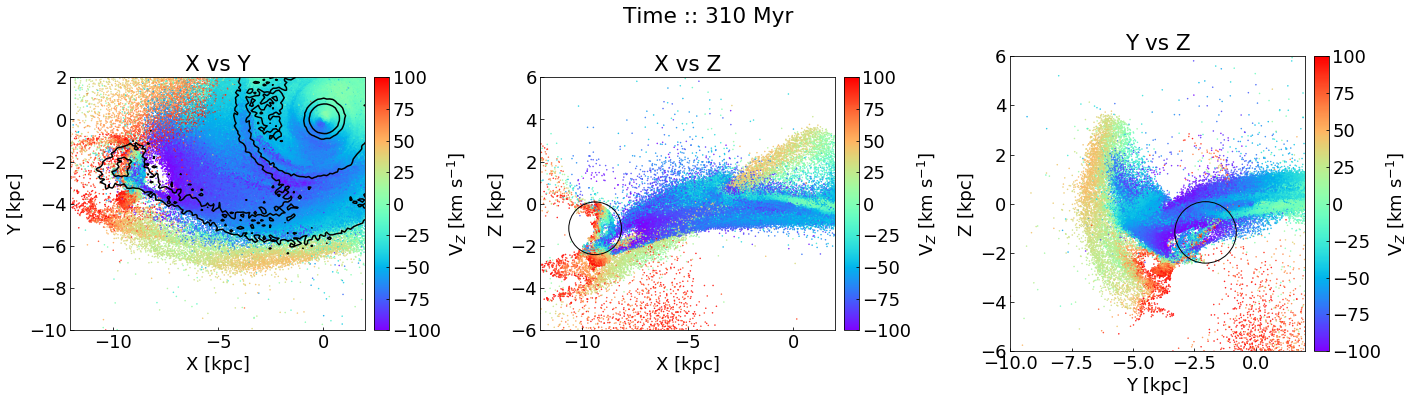

In [15]:
fig = plt.figure(figsize=(20, 6))
ax = [fig.add_subplot(1, 3, i+1) for i in range(3)]

xyz_x_min = [xmin, xmin, ymin]
xyz_x_max = [xmax, xmax, ymax]
xyz_y_min = [ymin, zmin, zmin]
xyz_y_max = [ymax, zmax, zmax]
xyz_x = [offset_x_bridge, offset_x_bridge, offset_y_bridge]
xyz_y = [offset_y_bridge, offset_z_bridge, offset_z_bridge]
m51b_x = [m51b_x, m51b_x, m51b_y]
m51b_y = [m51b_y, m51b_z, m51b_z]
title = ['X vs Y', 'X vs Z', 'Y vs Z']
cmap = 'rainbow'
# cmap = 'bwr'

for i in range(3):
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax[i])
    cax = divider.append_axes('right', '5%', pad='3%')
    sc  = ax[i].scatter(
        xyz_x[i],
        xyz_y[i],
        c=v_bridge,
        cmap=cmap, marker='.', s=1, alpha=1,
        vmin=vmin, vmax=vmax
    )
    cbar = plt.colorbar(sc, cax=cax)
    cbar.set_label('V$_Z$ [km s$^{-1}$]')
    
    ax[i].set_xlabel('{} [kpc]'.format(title[i][0]))
    ax[i].set_ylabel('{} [kpc]'.format(title[i][-1]))
    ax[i].set_title(title[i])
    ax[i].set_xlim(xyz_x_min[i], xyz_x_max[i])
    ax[i].set_ylim(xyz_y_min[i], xyz_y_max[i])
    ax[i].set_aspect('equal')                   

    if i in [1, 2]:
        c = patches.Circle(xy=(m51b_x[i], m51b_y[i]), radius=1.25, fc='none', ec='k', fill=True)
        ax[i].add_patch(c)

    if i == 0:
        counts, xedges, yedges, Image = ax[i].hist2d(
            offset_x_star_bridge,
            offset_y_star_bridge,
            bins=100, cmap=matplotlib.cm.binary,
            norm=matplotlib.colors.LogNorm(),
            alpha=0
        )
        cont = ax[i].contour(
            counts.transpose(),
            extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()],
            levels=[4e1, 1e2, 5e2, 1e3],
            colors='k'
        )
    
    print('[Info] Finished No.{} image...'.format(i+1))

fig.suptitle('Time :: ' + str(int(round(ti)))+' Myr')

plt.tight_layout()
# plt.subplots_adjust(top=0.8)   
# plt.savefig('../fig/Vz_{}Myr_xyz_{}_kms_to_{}_kms_{}_z{}to{}_with_contour_v1.png'.format((int(round(ti))), vmin, vmax, cmap, zmin, zmax), dpi=100)
plt.show()